# Numerical Optimization 2: More Constraints

This notebook uses the [NLopt package](https://github.com/JuliaOpt/NLopt.jl) which has well tested routines for constrained optimization.

(The `Optim` package has preliminary code for similar functionality, see the IPNewton section of the documentation.)

## Load Packages

In [1]:
using NLopt, Dates

include("printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Unconstrained Optimization

In the example below, we want to choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. The solution should be $(x,y)=(2,-3/4)$.

We use the algorithm `LN_COBYLA` which does not require us to code up the derivatives, but can still handle restrictions.

In [3]:
function lossfun(p,grad)    #grad is never used, but must be in function def
    (x,y) = (p[1],p[2])          
    L     = (x-2)^2 + (4*y+3)^2
    return L
end

lossfun (generic function with 1 method)

In [4]:
nx = 2*41
ny = 2*61
x = range(1,stop=5,length=nx)    
y = range(-1,stop=0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny                   
    loss2d[i,j] = lossfun([x[i];y[j]],[])
end

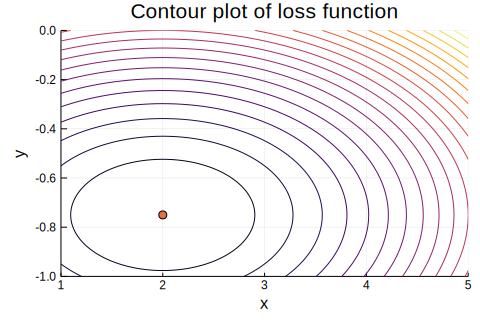

In [5]:
p1 = contour(x,y,loss2d',xlims=(1,5),ylims=(-1,0),legend=false,levels=21)  #notice: loss2d'
scatter!([2],[-0.75],label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

In [6]:
opt = Opt(:LN_COBYLA, 2)                  #unconstrained minimization
lower_bounds!(opt,[-100,-100])            #LN_COBYLA seems to need some restrictions 
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)                       #set convergence tolerance to a reasonable number  

(minf,minx,ret) = optimize(opt,[0.0,0.0])
println("minimum at $minx and $ret")

minimum at [2.0, -0.749999] and XTOL_REACHED


# Optimization with Bounds on the Parameters

The next few cells illustrate how to impose bounds like $a \leq x$ and $y \leq b$.

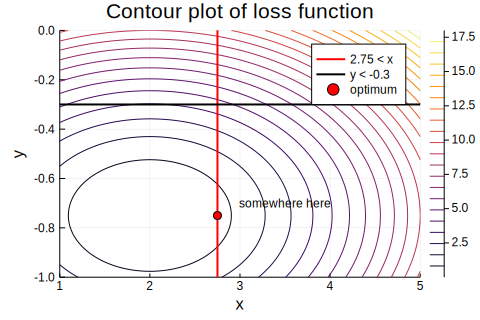

In [7]:
p1 = contour(x,y,loss2d',xlims=(1,5),ylims=(-1,0),levels=21) 
plot!([2.75,2.75],[-1,0.5],color=:red,linewidth=2,label="2.75 < x")
plot!([1,5],[-0.3,-0.3],color=:black,linewidth=2,label="y < -0.3")
scatter!([2.75],[-0.75],color=:red,label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")
annotate!(3.5,-0.7,text("somewhere here",8))

In [8]:
opt = Opt(:LN_COBYLA, 2)               #bounds on the parameters
lower_bounds!(opt,[2.75, -Inf])
upper_bounds!(opt,[Inf, -0.3])
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)                   

(minf,minx,ret) = optimize(opt,[3.0, -0.5])
println("minimum at $minx and $ret")

minimum at [2.75, -0.75] and XTOL_REACHED


# Optimization with Equality Constraints

We now impose the constraint that $x+2y-3=0.$

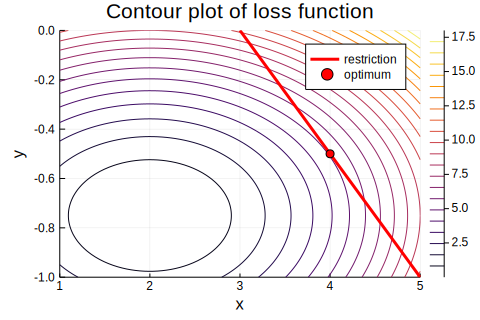

In [9]:
p1 = contour(x,y,loss2d',xlims=(1,5),ylims=(-1,0),levels=21) 
plot!(3 .- 2*y,y,color=:red,linewidth=3,label="restriction")
scatter!([4],[-0.5],color=:red,label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

In [10]:
function EqConstrfun(p,grad)   #equality constraint
    (x,y) = (p[1],p[2])          
    c  = x + 2*y - 3                       
    return c
end

opt = Opt(:LN_COBYLA, 2)                   
equality_constraint!(opt,(p,g) -> EqConstrfun(p,g))
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)

(minf,minx,ret) = optimize(opt,[3.0, 0.0])
println("minimum at $minx and $ret")

minimum at [4.0, -0.5] and XTOL_REACHED


# Optimization with Inequality Constraints

We now impose the constraint that $y \le -(x-4)^2$.

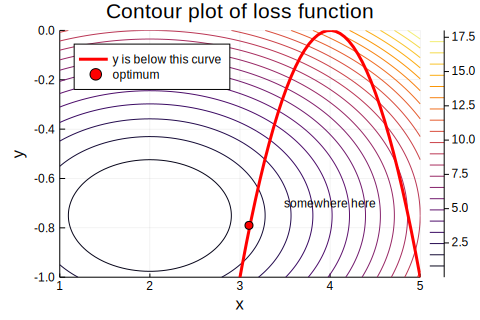

In [11]:
yRestriction = -(x.-4).^2               #y should be less than this

p1 = contour(x,y,loss2d',levels=21) 
plot!(x,yRestriction,xlims=(1,5),ylims=(-1,0),color=:red,linewidth=3,label="y is below this curve")
scatter!([3.1],[-0.79],color=:red,label="optimum",legend=:topleft)
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")
annotate!(4.0,-0.7,text("somewhere here",8))

In [12]:
function IneqConstrfun(p,grad)     #inequality restriction, <=
    (x,y) = (p[1],p[2])          
    r  = y + (x-4)^2             
  return r
end

opt = Opt(:LN_COBYLA, 2)
inequality_constraint!(opt,(p,g) -> IneqConstrfun(p,g))
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)                               

(minf,minx,ret) = optimize(opt,[4.0, -0.1])
println("minimum at $minx and $ret")

minimum at [3.11168, -0.789108] and XTOL_REACHED
